In [1]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
begin = '2010-01-01'
yf.pdr_override() 
ticker = 'PG'
df = pdr.get_data_yahoo(ticker, begin)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,61.110001,61.310001,60.630001,61.119999,40.160061,9190800
2010-01-05,61.130001,61.279999,60.599998,61.139999,40.173203,8649400
2010-01-06,60.939999,60.959999,60.500000,60.849998,39.982647,9908400
2010-01-07,60.580002,60.700001,60.240002,60.520000,39.765823,8972800
2010-01-08,60.360001,60.529999,60.060001,60.439999,39.713264,8464600
...,...,...,...,...,...,...
2024-04-10,155.649994,157.580002,155.649994,157.240005,157.240005,7784900
2024-04-11,157.550003,157.600006,155.770004,155.839996,155.839996,8209800
2024-04-12,155.220001,155.970001,154.740005,155.330002,155.330002,6770500


<Axes: xlabel='Date'>

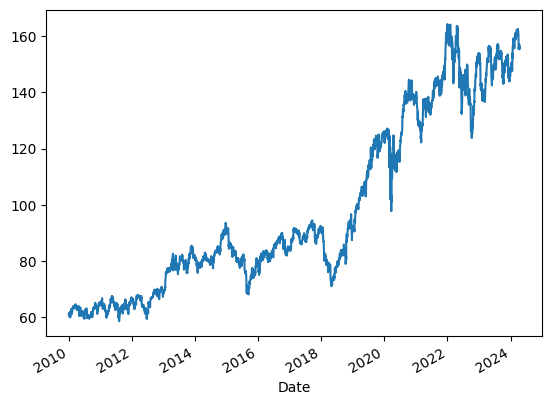

In [3]:
close = df['Close']

close.plot()

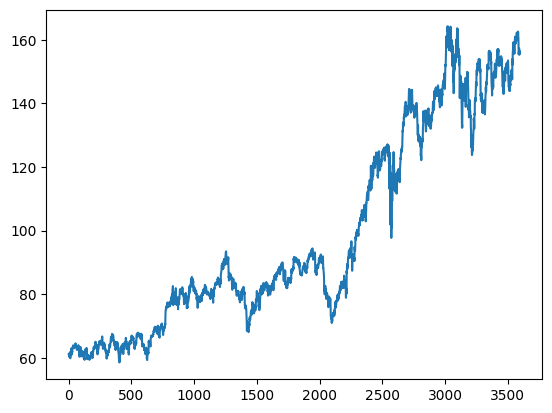

In [4]:
ds = close.values
plt.plot(ds)

In [5]:
from sklearn.preprocessing import MinMaxScaler

#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [6]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70) # train set is 70%
test_size = len(ds_scaled) - train_size # test is the other 30%

In [7]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),: 1]

In [8]:
#creating dataset in time series for LSTM model 
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [9]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [10]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [11]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

2024-04-16 12:00:12.172465: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 12:00:15.474604: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [13]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=30,batch_size=64)

Epoch 1/30
38/38 [==============================] - 10s 164ms/step - loss: 2.8599e-04 - val_loss: 8.6006e-04
Epoch 2/30
38/38 [==============================] - 5s 138ms/step - loss: 1.1610e-04 - val_loss: 3.7835e-04
Epoch 3/30
38/38 [==============================] - 5s 141ms/step - loss: 1.0415e-04 - val_loss: 5.0862e-04
Epoch 4/30
38/38 [==============================] - 5s 145ms/step - loss: 1.0888e-04 - val_loss: 2.9981e-04
Epoch 5/30
38/38 [==============================] - 5s 142ms/step - loss: 1.0623e-04 - val_loss: 8.5883e-04
Epoch 6/30
38/38 [==============================] - 5s 138ms/step - loss: 1.0188e-04 - val_loss: 2.8460e-04
Epoch 7/30
38/38 [==============================] - 5s 138ms/step - loss: 1.0749e-04 - val_loss: 3.4916e-04
Epoch 8/30
38/38 [==============================] - 5s 140ms/step - loss: 9.4796e-05 - val_loss: 3.9808e-04
Epoch 9/30
38/38 [==============================] - 5s 141ms/step - loss: 9.7390e-05 - val_loss: 5.1757e-04
Epoch 10/30
38/38 [========

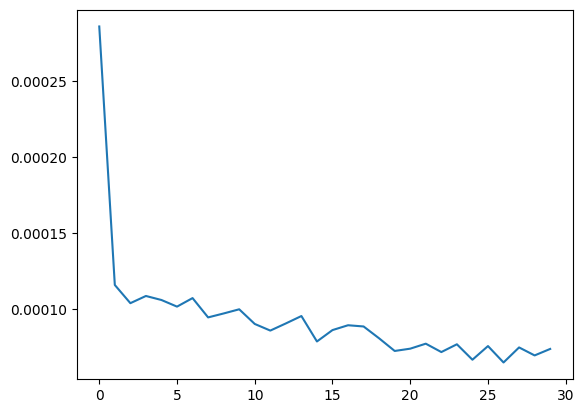

In [14]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss, label='Loss')

In [15]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

31/31 [==============================] - 1s 29ms/step


In [16]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

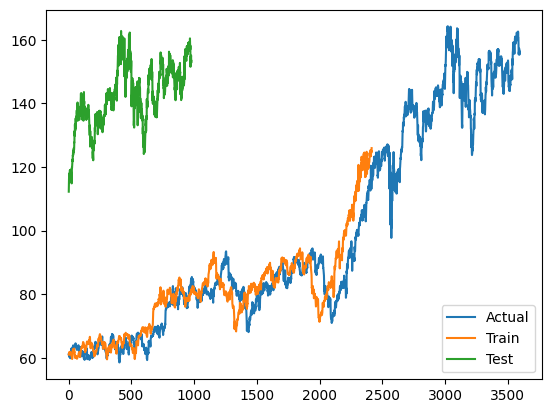

In [17]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled), label="Actual")
plt.plot(train_predict, label="Train")
plt.plot(test_predict, label="Test")
plt.legend()

In [18]:
test = np.vstack((train_predict,test_predict))

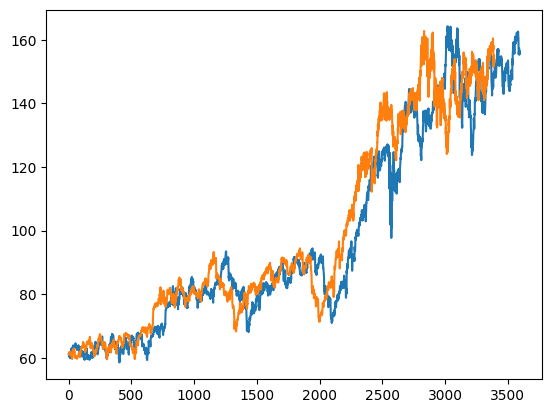

In [19]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test, label='Test')

In [23]:
#Getting the last 100 days records
fut_inp = ds_test[978:]
print(len(fut_inp))

101


In [24]:
fut_inp = fut_inp.reshape(1,-1)
tmp_inp = list(fut_inp)

#Creating list of the last 728 data
tmp_inp = tmp_inp[0].tolist()

In [25]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
print(lst_output)

print(len(ds_scaled))

[[0.9084601402282715], [0.878064751625061], [0.8524722456932068], [0.8377957940101624], [0.8308160305023193], [0.8262450098991394], [0.8208577036857605], [0.8139680027961731], [0.8062670230865479], [0.7986375689506531], [0.7915720343589783], [0.7851370573043823], [0.7791779041290283], [0.7735176682472229], [0.7680495977401733], [0.7627410888671875], [0.7575991749763489], [0.7526376247406006], [0.7478607296943665], [0.7432616949081421], [0.7388274073600769], [0.7345440983772278], [0.7304001450538635], [0.7263860702514648], [0.7224958539009094], [0.7187232375144958], [0.7150633335113525], [0.7115098237991333], [0.708058774471283], [0.7047048211097717]]
3595


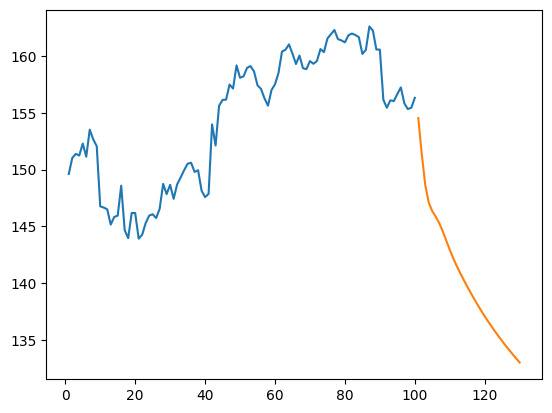

In [44]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[3495:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

3625


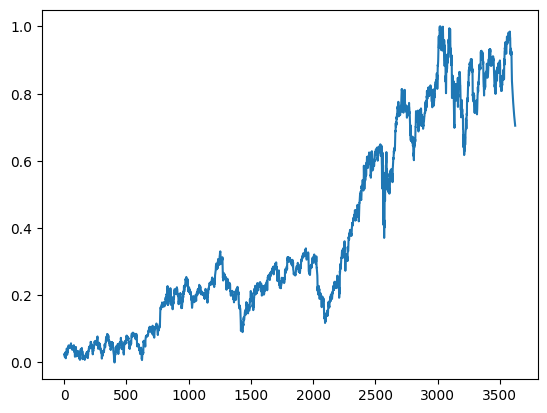

In [45]:
ds_new = ds_scaled.tolist()
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new)
print(len(ds_new))

In [46]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

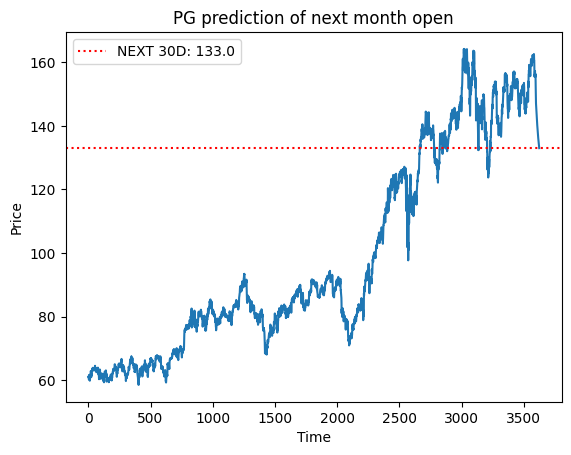

In [47]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(ticker))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()